In [24]:
import pandas as pd 
from utils import *
from training import *

fleet = ['VQ-BGU', 'VQ-BDU']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm']).query('oat > -100')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm']).query('oat > -100')

# bgu.loc[bgu['oat'].isna(), ['oat']] = bgu.loc[bgu['oat'].isna(), :]['tat']
# bdu.loc[bdu['oat'].isna(), ['oat']] = bdu.loc[bdu['oat'].isna(), :]['tat']

Correction procedure

In [25]:
def correct(data):
  datak = data.copy()
  alpha = 0.5
  theta = (data['oat'] + 273.15) / 288.15
  theta_tat = (data['tat'] + 273.15) / 288.15
  delta = (data['p2e'] * 68.948) / 1013.25

  datak['nfk'] = data['nf'] / (theta ** alpha)
  datak['n1ak'] = data['n1a'] / (theta ** alpha)
  datak['n1k'] = data['n1'] / (theta ** alpha)
  datak['n2ak'] = data['n2a'] / (theta ** alpha)
  datak['egtk'] = (data['egt'] + 273.15) / theta
  datak['egtk_tat'] = (data['egt'] + 273.15) / theta_tat
  datak['ffk'] = (data['ff']) / (delta * (theta ** alpha))

  return datak

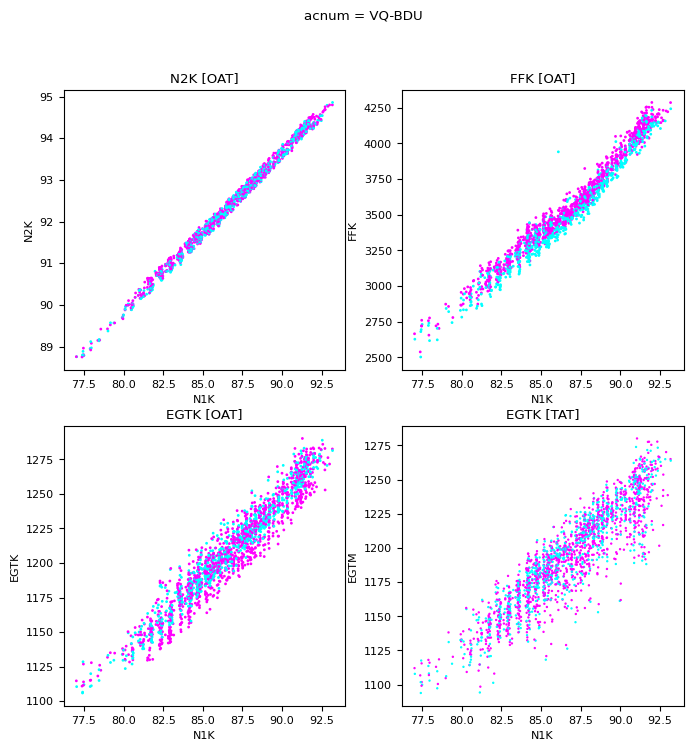

In [31]:
features = ['egt', 'tat', 'oat', 'n1a', 'n2a', 'n1p', 'n1c2', 'n2p', 'n1ak', 'n2ak', 'ffk', 'egtk', 'egtk_tat', 'ff', 'nf']

data = build_dataset(
  [correct(bdu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=0,
)

plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
fig.suptitle('acnum = VQ-BDU')

axs[0, 0].scatter(data['n1ak'], data['n2ak'], s=1, c=data['pos'], cmap='cool')
axs[0, 0].set(xlabel='N1K', ylabel='N2K')
axs[0, 0].set_title('N2K [OAT]')

axs[0, 1].scatter(data['n1ak'], data['ffk'], s=1, c=data['pos'], cmap='cool')
axs[0, 1].set(xlabel='N1K', ylabel='FFK')
axs[0, 1].set_title('FFK [OAT]')

axs[1, 0].scatter(data['n1ak'], data['egtk'], s=1, c=data['pos'], cmap='cool')
axs[1, 0].set(xlabel='N1K', ylabel='EGTK')
axs[1, 0].set_title('EGTK [OAT]')

axs[1, 1].scatter(data['n1ak'], data['egtk_tat'], s=0.5, c=data['pos'], cmap='cool')
axs[1, 1].set(xlabel='N1K', ylabel='EGTM')
axs[1, 1].set_title('EGTK [TAT]')

plt.show()

Train a baseline:

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()

model.fit(data[['n1ak']], data['egtk'])

pred = model.predict(data[['n1ak']])

r2 = r2_score(data['egtk'],  pred)

print(f"R2 = {r2}")

R2 = 0.9342838414210677


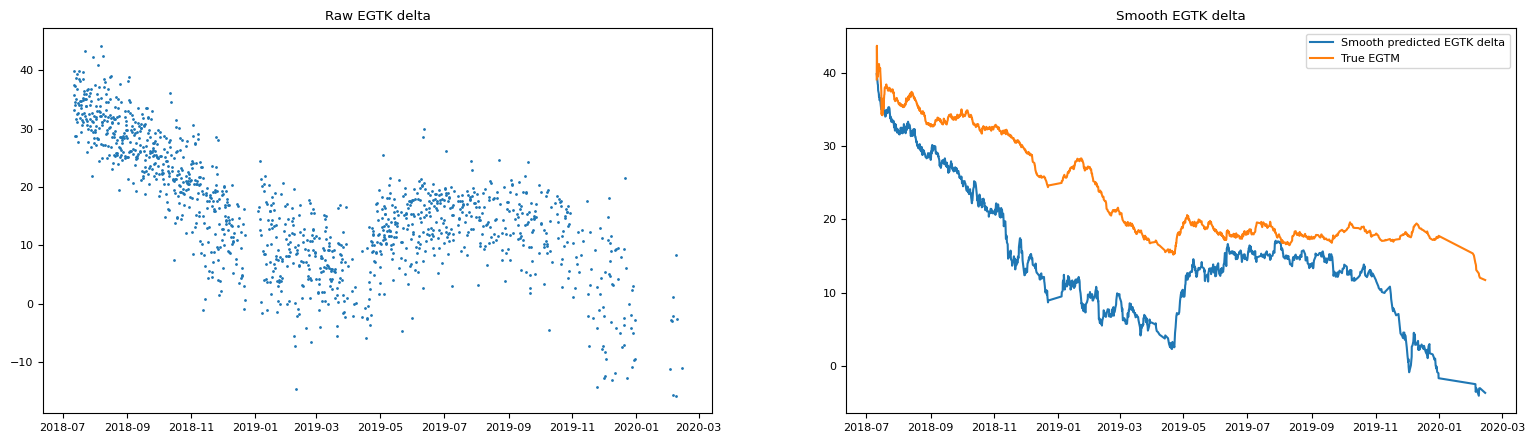

In [28]:
sub = data[data['pos'] == 2]
baseline = model.predict(sub[['n1ak']])
delta = baseline - sub['egtk'] + 15

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  delta, s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(delta, alpha=0.08))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

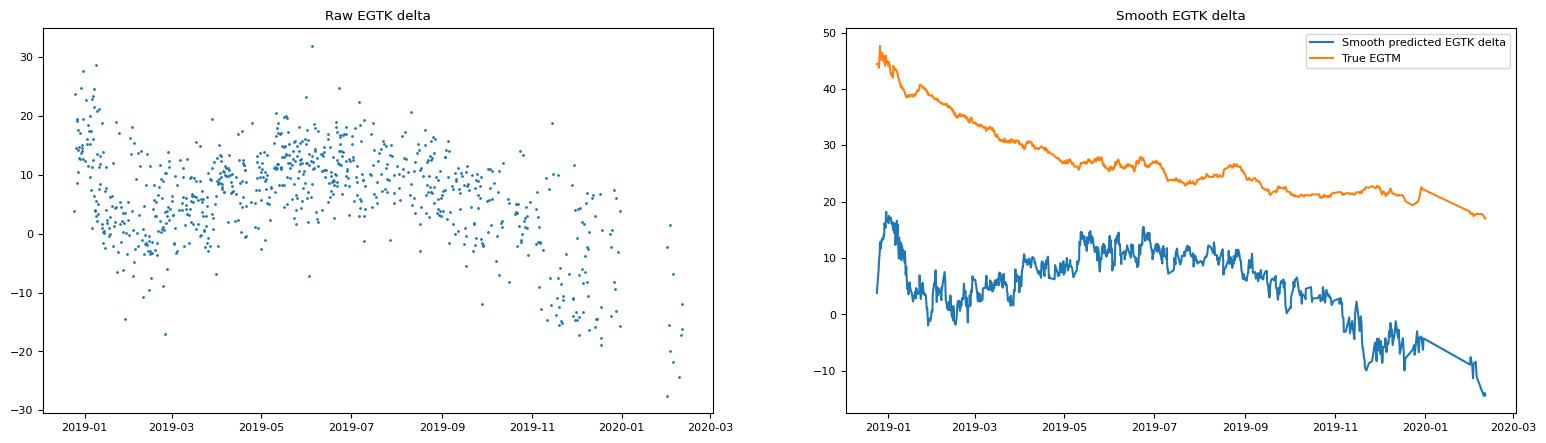

In [29]:
data_bgu = build_dataset(
  [correct(bgu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=0,
)

sub = data_bgu[data_bgu['pos'] == 1]
baseline = model.predict(sub[['n1ak']])
delta = baseline - sub['egtk']

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  delta, s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(delta, alpha=0.2))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])


plt.show()

1. Вывести Delta EGTK из train выборки (75%)
2. Предсказать Delta EGTK для всего датасета и добавить как признак
3. Сравнить качество с Экспериментом 5 